In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

Using TensorFlow backend.


## Loading Dataset

Considering only more than 4 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [2]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    if (label == "normal"):
                        dataset.append({
                            "filename": filename,
                            "label": "normal"
                        })
                    else:
                        dataset.append({
                            "filename": filename,
                            "label": "abnormal"
                        })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

TODO: Find a way to use the data with less the 4 seconds

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 193 to 102
Data columns (total 2 columns):
filename    364 non-null object
label       364 non-null object
dtypes: object(2)
memory usage: 8.5+ KB


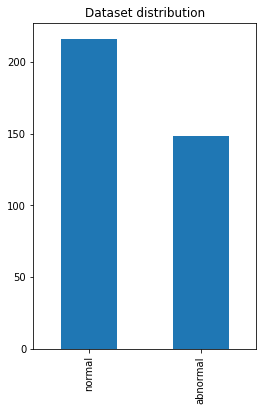

In [4]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [5]:
train, test = train_test_split(dataset, test_size=0.2)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 291
Test: 73


## Visualising the data and features

./set_b/normal__137_1306764999211_C.wav
./set_b/murmur__116_1306258689913_D.wav


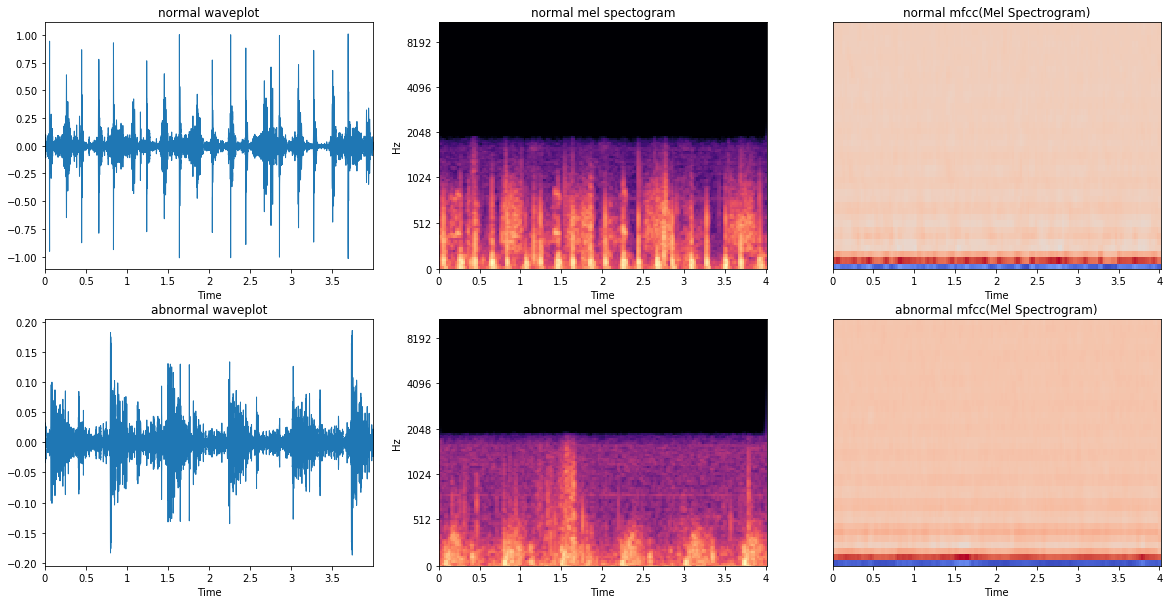

In [6]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=4)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [7]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [8]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 73/73 [00:06<00:00, 13.42it/s]

X train: (291, 40, 173)
X test: (73, 40, 173)


In [9]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

## Input Shapes

In [10]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (291, 40, 173, 1)
Y train: (291, 2)
X test: (73, 40, 173, 1)
Y test: (73, 2)


## Building Model

In [11]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 41, 64)       

## Compiling Model

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Fitting Model

In [13]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)


Train on 291 samples, validate on 73 samples
Epoch 1/300
291/291 [==============================] - 1s 3ms/step - loss: 4.6595 - accuracy: 0.5052 - val_loss: 2.2083 - val_accuracy: 0.5479
Epoch 2/300
291/291 [==============================] - 1s 2ms/step - loss: 4.8078 - accuracy: 0.5498 - val_loss: 1.9997 - val_accuracy: 0.5479
Epoch 3/300
291/291 [==============================] - 1s 2ms/step - loss: 2.9491 - accuracy: 0.5189 - val_loss: 0.7403 - val_accuracy: 0.6301
Epoch 4/300
291/291 [==============================] - 1s 2ms/step - loss: 2.8267 - accuracy: 0.5052 - val_loss: 2.0032 - val_accuracy: 0.5479
Epoch 5/300
291/291 [==============================] - 1s 2ms/step - loss: 3.0047 - accuracy: 0.5636 - val_loss: 0.7926 - val_accuracy: 0.5890
Epoch 6/300
291/291 [==============================] - 1s 2ms/step - loss: 1.9912 - accuracy: 0.5498 - val_loss: 0.6510 - val_accuracy: 0.6301
Epoch 7/300
291/291 [==============================] - 1s 2ms/step - loss: 1.5573 - accuracy: 0.

291/291 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.6426 - val_loss: 0.6482 - val_accuracy: 0.6301
Epoch 57/300
291/291 [==============================] - 1s 2ms/step - loss: 0.6034 - accuracy: 0.6838 - val_loss: 0.6461 - val_accuracy: 0.6301
Epoch 58/300
291/291 [==============================] - 1s 2ms/step - loss: 0.6154 - accuracy: 0.6460 - val_loss: 0.6447 - val_accuracy: 0.6301
Epoch 59/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5772 - accuracy: 0.6838 - val_loss: 0.6447 - val_accuracy: 0.6301
Epoch 60/300
291/291 [==============================] - 1s 2ms/step - loss: 0.6076 - accuracy: 0.6907 - val_loss: 0.6372 - val_accuracy: 0.6301
Epoch 61/300
291/291 [==============================] - 1s 2ms/step - loss: 0.6196 - accuracy: 0.6804 - val_loss: 0.6364 - val_accuracy: 0.6301
Epoch 62/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5829 - accuracy: 0.7148 - val_loss: 0.6425 - val_accuracy: 0.6301
Epoch

Epoch 113/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7388 - val_loss: 0.5957 - val_accuracy: 0.6986
Epoch 114/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.6976 - val_loss: 0.5924 - val_accuracy: 0.6986
Epoch 115/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5604 - accuracy: 0.6735 - val_loss: 0.5995 - val_accuracy: 0.6849
Epoch 116/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5486 - accuracy: 0.7388 - val_loss: 0.6038 - val_accuracy: 0.6986
Epoch 117/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5656 - accuracy: 0.7045 - val_loss: 0.5990 - val_accuracy: 0.7123
Epoch 118/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5582 - accuracy: 0.6873 - val_loss: 0.6030 - val_accuracy: 0.7260
Epoch 119/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5449 - accuracy: 0.6942 - val_loss: 0.6103 - val_ac

291/291 [==============================] - 1s 3ms/step - loss: 0.5277 - accuracy: 0.7182 - val_loss: 0.5849 - val_accuracy: 0.6849
Epoch 170/300
291/291 [==============================] - 1s 3ms/step - loss: 0.5330 - accuracy: 0.7182 - val_loss: 0.5861 - val_accuracy: 0.6986
Epoch 171/300
291/291 [==============================] - 1s 3ms/step - loss: 0.5304 - accuracy: 0.7285 - val_loss: 0.5865 - val_accuracy: 0.6575
Epoch 172/300
291/291 [==============================] - 1s 3ms/step - loss: 0.5218 - accuracy: 0.7113 - val_loss: 0.5878 - val_accuracy: 0.6575
Epoch 173/300
291/291 [==============================] - 1s 3ms/step - loss: 0.5016 - accuracy: 0.7457 - val_loss: 0.5875 - val_accuracy: 0.6575
Epoch 174/300
291/291 [==============================] - 1s 3ms/step - loss: 0.5231 - accuracy: 0.7457 - val_loss: 0.5850 - val_accuracy: 0.6438
Epoch 175/300
291/291 [==============================] - 1s 3ms/step - loss: 0.5197 - accuracy: 0.7354 - val_loss: 0.5794 - val_accuracy: 0.7123

291/291 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7182 - val_loss: 0.5869 - val_accuracy: 0.6849
Epoch 226/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5033 - accuracy: 0.7423 - val_loss: 0.6109 - val_accuracy: 0.6438
Epoch 227/300
291/291 [==============================] - 1s 3ms/step - loss: 0.5272 - accuracy: 0.7354 - val_loss: 0.5808 - val_accuracy: 0.6986
Epoch 228/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5184 - accuracy: 0.7320 - val_loss: 0.5706 - val_accuracy: 0.7123
Epoch 229/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5360 - accuracy: 0.7285 - val_loss: 0.5702 - val_accuracy: 0.7260
Epoch 230/300
291/291 [==============================] - 1s 2ms/step - loss: 0.5083 - accuracy: 0.7560 - val_loss: 0.5792 - val_accuracy: 0.6849
Epoch 231/300
291/291 [==============================] - 1s 2ms/step - loss: 0.4962 - accuracy: 0.7560 - val_loss: 0.5787 - val_accuracy: 0.6849

291/291 [==============================] - 1s 2ms/step - loss: 0.4597 - accuracy: 0.7732 - val_loss: 0.6168 - val_accuracy: 0.6712
Epoch 282/300
291/291 [==============================] - 1s 2ms/step - loss: 0.4546 - accuracy: 0.7595 - val_loss: 0.6112 - val_accuracy: 0.6986
Epoch 283/300
291/291 [==============================] - 1s 2ms/step - loss: 0.4720 - accuracy: 0.7698 - val_loss: 0.6117 - val_accuracy: 0.7260
Epoch 284/300
291/291 [==============================] - 1s 2ms/step - loss: 0.4308 - accuracy: 0.7869 - val_loss: 0.6018 - val_accuracy: 0.6986
Epoch 285/300
291/291 [==============================] - 1s 2ms/step - loss: 0.4730 - accuracy: 0.7491 - val_loss: 0.5927 - val_accuracy: 0.7123
Epoch 286/300
291/291 [==============================] - 1s 2ms/step - loss: 0.4469 - accuracy: 0.7835 - val_loss: 0.5895 - val_accuracy: 0.6712
Epoch 287/300
291/291 [==============================] - 1s 2ms/step - loss: 0.4540 - accuracy: 0.7869 - val_loss: 0.5988 - val_accuracy: 0.7123

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

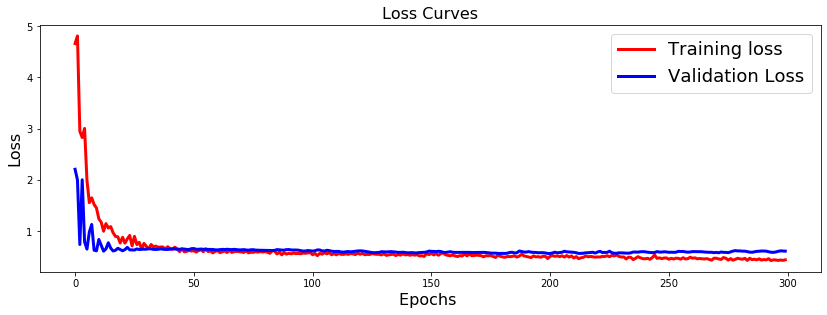

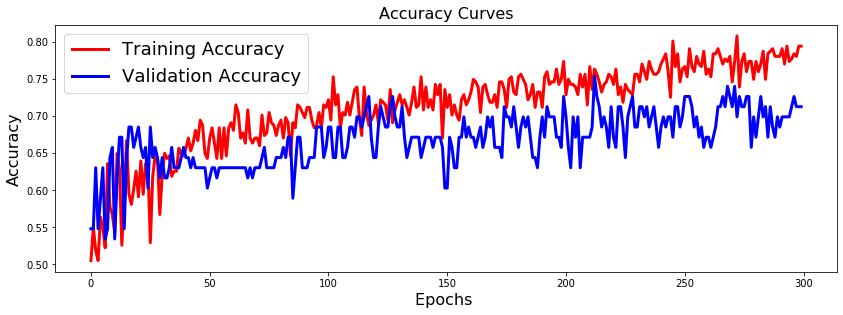

In [14]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [15]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

73/73 [==============================] - 0s 524us/step
Test loss: 0.6115370821462919
Test accuracy: 0.7123287916183472


In [16]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

73/73 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    abnormal       0.61      0.71      0.66        28
      normal       0.80      0.71      0.75        45

    accuracy                           0.71        73
   macro avg       0.70      0.71      0.70        73
weighted avg       0.73      0.71      0.72        73



### Save Model and Weights

In [17]:
model_name = "heartbeat_classifier.h5"
model.save(model_name)